In [52]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

Assistance with utilizing k-fold for validation

[https://isheunesu48.medium.com/cross-validation-using-k-fold-with-scikit-learn-cfc44bf1ce6]
(This is for a KNN model so it utilizes a classification validation)

Instead we will make use of MSE and R^2

In [53]:
#import model from step 6
def sums(x, y):
    '''
    This function creates all the necessary sums for the linear regression equations
    Inputs:
        x (np array) data that will be used to make predictions
        y (np array) data that will be used to check predictions
    Outputs:
        sum_x (float) sum of all the x values
        sum_y (float) sum of all the y values
        sum_x2 (float) sum of all the squared x values
        sum_xy (float) sum of all the x values multiplied by their respective y values
    '''
    sum_x = np.sum(x)
    sum_y = np.sum(y)
    sum_x2 = np.sum(x**2)
    sum_xy = np.sum(x*y)
    return sum_x, sum_y, sum_x2, sum_xy
def B_i(x,y):
    '''
    This function calculates the slope (B_1) and intercept (B_0) of the regression
    Inputs:
        x (np array) data that will be used to make predictions
        y (np array) data that will be used to check predictions
    Outputs:
        B1 (float) slope of the regression
        B0 (float) intercept for the regression
    '''
    sum_x, sum_y, sum_x2, sum_xy = sums(x,y)
    numerator = ((len(x) * sum_xy) - (sum_x * sum_y))
    denominator = ((len(x) * sum_x2) - (sum_x**2))
    B1 = numerator/denominator
    B0 = (sum_y - (B1 * sum_x)) / len(x)
    return B1, B0
def ridge_regression(x, y, Lr=0.1, penalty=0.1, epochs=10000):
    '''
    This function does a gradient descent for ridge regression.
    input:
        x: np array, predictor values
        y: np array, target values
        lr: float, learning rate
        lambda: float, ridge regularization strength
        epochs: int, number of iterations
    output:
        B: array with floats, Contains both the slopes and intercept after the gradient descent
    '''
    m, n = x.shape  #m = number of samples, n = number of features
    slope = []
    intercept = []
    #My B_i fxn is meant for only one predictor so if i want to expand it to a matrix it will need to change a bit
    for i in range(n):
        B1, B0 = B_i(x[:,i], y[i])  #Apply B_i for each row of x
        slope.append(B1)
        intercept.append(B0)
    B = np.zeros((n+1, 1))  #Initialize weights
    B[0] = intercept  #The first row is for intercepts
    B[1:] = np.array(slope).reshape(-1, 1)  #The rest are for slopes

    #need a column in X of ones to account for B having the intercept
    x_B = np.ones((m,n+1))
    x_B[:,1:] = x #now x_B has x as well as a column to account to intercepts

    for epoch in range(epochs):
        Y_pred = np.dot(x_B, B) #calculate predicted y vals
        err = Y_pred - y #find residuals

        B_pen = np.copy(B) #Creating a copy of B to not interfere with updating it
        B_pen[0] = 0 #set the intercept to 0
        
        dB = (1/m) * (np.dot(x_B.T, err) + penalty * B_pen) #calculate change
        B -= Lr * dB #apply changes to B

    return B

In [54]:
#Grab and normalize data like in step6 
data = pd.read_csv('FY_2025_Hospital_Readmissions_Reduction_Program_Hospital.csv')
data = data.drop(columns = ['Footnote'])
data = data.dropna()
data['Number of Readmissions'] = data['Number of Readmissions'].astype(float)
data['Read_Dis_ratio'] = data['Number of Readmissions'] / data['Number of Discharges']
X_both = data['Read_Dis_ratio']
X = data['Number of Discharges']
Y = data['Excess Readmission Ratio']
mean_X = np.mean(X)
std_dev_X = np.std(X)
normal_X = (X-mean_X)/std_dev_X
normal_X = np.array(normal_X).reshape(-1,1)
Y = np.array(Y).reshape(-1,1)

In [ ]:
'''
%Warning%
Runtime ~ 45 sec
'''
all_MSE = []
all_R2 = []
all_k = []
k_list = np.arange(2,21,1)
for k in k_list:
    kFold=KFold(n_splits=k,shuffle=False) #using package for k-fold
    cur_MSE = [] #for this K this will hold the scoring metrics
    cur_R2 = []
    for train_index,test_index in kFold.split(X): #creates indeces for the splits for this K
        X_train, X_test, y_train, y_test = normal_X[train_index], normal_X[test_index], Y[train_index], Y[test_index] #Creates the test/train splits
        B = ridge_regression(X_train,y_train,epochs=1000) #puts the training set through the model
        #print(B)
        Y_pred = B[0] + B[1]*X_test #creates predictions for the test data
        MSE = (1/len(Y_pred))*np.sum((Y_pred-y_test)**2) #calculates MSE
        RSS = np.sum((Y_pred - y_test)**2)
        TSS = np.sum((y_test - np.mean(y_test))**2)
        R2 = 1 - (RSS/TSS) #calculates R^2
        cur_MSE.append(MSE)
        cur_R2.append(R2)
        '''
        I think I don't need the avg around here which I realize as I comment this.
        I don't want to break it now that it's working but it shouldn't add much runtime if its doing an avg of one value.
        '''
    avg_mse = np.mean(cur_MSE) #finds the avg value for this k
    avg_r2 = np.mean(cur_R2) #finds the avg for this k
    all_MSE.append(avg_mse)
    all_R2.append(avg_r2)
    all_k.append(k)


Assisted in developing evaluation [https://towardsdatascience.com/evaluation-metrics-model-selection-in-linear-regression-73c7573208be/]

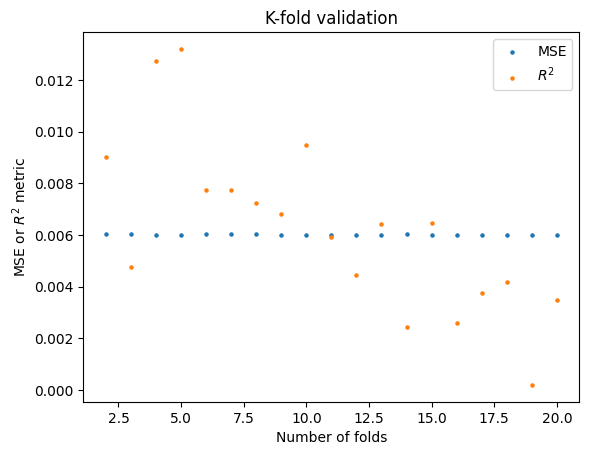

In [ ]:
#plot the score metrics
plt.scatter(all_k, all_MSE, s=5, label='MSE')
plt.scatter(all_k, all_R2, s=5, label=r'$R^2$')
plt.xlabel('Number of folds')
plt.ylabel(r'MSE or $R^2$ metric')
plt.title('K-fold validation')
plt.legend()
plt.show()

As we can see the MSE stays constantas we increase the number of folds. This shows that the model is consistent with its error compared to the data. However the R^2 values tend to decrease with more folds. This tells us the model is poor at describing the variance in the model.

Due to the high variance in the dataset to begin with this should be a good sign because the MSE stays constant. This tells us the model is good at making predictions. So in this case a consistent MSE would be more meaningful than the low R^2.